# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline. 
Complete the code where you see XXXXXXXXXXXXXXXXX (mandatory for everybody)

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline as make_pipeline2
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mpl_toolkits.axes_grid1 import AxesGrid
from skimage.io import imread
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from time import time

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [4]:
# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Then load the data from my Google Drive

In [5]:
# from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
# dest_path='./data/features.csv')
# gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
# dest_path='./data/im/nevus-seg.jpg')
# gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
# dest_path='./data/im/nevus.jpg')
# gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
# dest_path='./data/im/melanoma-seg.jpg')
# gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
# dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [6]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))

Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented nevus')

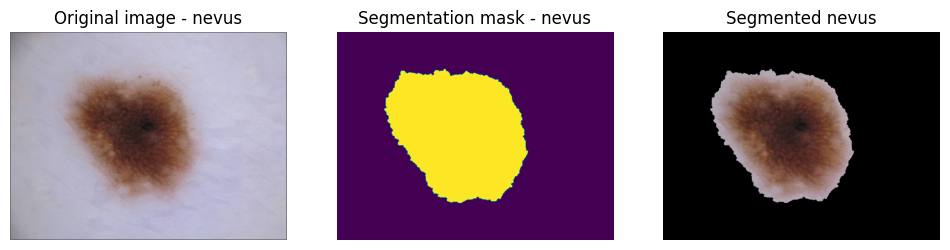

In [7]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

Text(0.5, 1.0, 'Segmented melanoma')

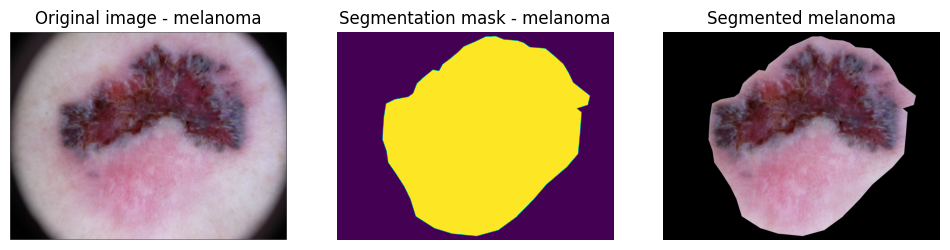

In [8]:
melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [9]:
# Shuffle data randomly
Xp = np.copy(X)
yp = np.copy(y)
np.random.seed(0)
idx = np.random.permutation(N)
Xp = Xp[idx,:]
yp = yp[idx]

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

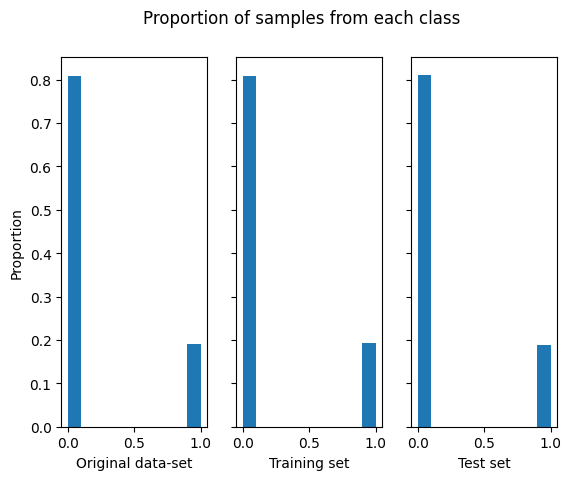

In [10]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42, stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ? (For simplicity's sake, we will restrict here to scaling all features).

In machine learning, particularly for models like SVMs, proper feature scaling is crucial to prevent data leakage and ensure the model's generalizability to unseen data. The process involves computing scaling parameters specifically, the mean and standard deviation for each feature based on the training set. 

This approach is adopted because the training set is what the model learns from, and thus, all parameter computations should be restricted to this data set to avoid any inadvertent leakage of information from the test set into the model. This ensures that the scaling reflects the true distribution of the features as encountered during training, maintaining the integrity of the model's learning process.

Once the scaling parameters are determined from the training set, the same transformation is then uniformly applied to both the training and the test sets. This involves subtracting the training set's feature-wise mean from each corresponding feature in both sets and then dividing by the standard deviation computed from the training set. By doing so, we achieve a consistent scaling across both data sets, ensuring that the test set serves as a valid representation of new, unseen data. 

In [11]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices. 

**Question**: Comment the results. 

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       146
           1       0.65      0.38      0.48        34

    accuracy                           0.84       180
   macro avg       0.76      0.67      0.69       180
weighted avg       0.83      0.84      0.83       180

Normalized confusion matrix
[[0.95205479 0.04794521]
 [0.61764706 0.38235294]]


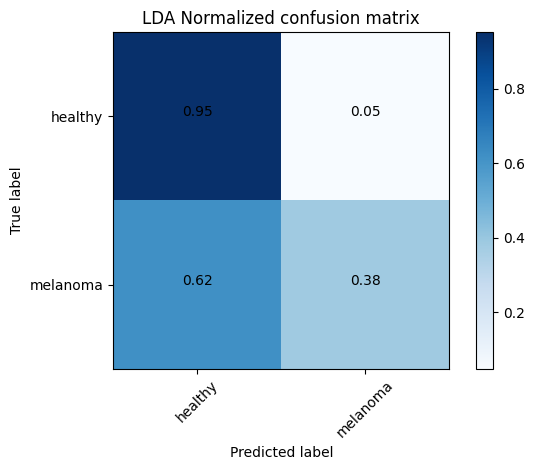

Fitting QDA to training set
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       146
           1       0.65      0.38      0.48        34

    accuracy                           0.84       180
   macro avg       0.76      0.67      0.69       180
weighted avg       0.83      0.84      0.83       180

Normalized confusion matrix
[[0.95205479 0.04794521]
 [0.61764706 0.38235294]]


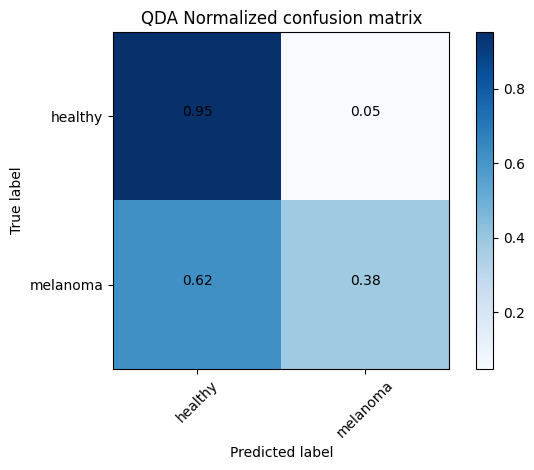

In [12]:
# Fitting LDA
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred = lda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("Fitting QDA to training set")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scale, y_train)
y_pred = qda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()

The similar performance metrics between Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA) in classifying cases of "healthy" and "melanoma" indicate that, despite their theoretical differences, they function similarly under certain conditions. Both classifiers achieve a true positive rate of 0.95 for "healthy," correctly identifying 95% of healthy cases, and a true positive rate of 0.62 for "melanoma," correctly predicting 62% of melanoma cases. 

This similarity extends to the false negative rate for melanoma, which is high at 0.38 for both models, meaning 38% of melanoma cases are missed, and a low false positive rate for healthy at 0.05, where 5% of healthy cases are incorrectly identified as melanoma.

These consistent metrics may result from several factors inherent to the models and the data they are applied to. LDA's assumptions about normal distribution of predictors and equal covariance across classes might not significantly differ from the actual data distribution, making its performance comparable to QDA, which does not make these assumptions and allows for different covariances per class. 

Additionally, if QDA is overfitting the training data, its ability to generalize might be compromised, negating the benefits of its more flexible decision boundary. Furthermore, if the true decision boundary between classes is relatively linear, the advantages of QDA's flexibility would be minimized, resulting in similar performance to LDA.

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

In feature scaling for models like SVMs, it's important to compute scaling parameters—mean and standard deviation—using only the training set to avoid information leakage from the test set. These parameters are then applied to both the training and test sets, ensuring the model's evaluation on the test set reflects its performance on new, unseen data. 

Cross-validation, particularly k-fold cross-validation, enhances model performance evaluation by dividing the dataset into k segments. The model is trained and tested across these segments in a rotational fashion, allowing each data point to be used for both training and testing. 

In [13]:
# Set up the cross-validation scheme
k_folds = 5

# Initialize models
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
knn = KNeighborsClassifier(n_neighbors = 5) 

# For each model, perform k-fold cross-validation
for model_name, model in [('LDA', lda), ('QDA', qda), ('k-NN', knn)]:
    
    # Pipeline that first scales the data then applies the model
    pipeline = make_pipeline(StandardScaler(), model)
    
    # Evaluate model
    scores = cross_val_score(pipeline, X, y, cv=k_folds, scoring='accuracy')
    
    print(f"{model_name} accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LDA accuracy: 0.80 (+/- 0.05)
QDA accuracy: 0.79 (+/- 0.02)
k-NN accuracy: 0.81 (+/- 0.04)


The k-fold cross-validation comparison of LDA, QDA, and k-NN classifiers reveals closely matched performances, with k-NN slightly leading at 81% accuracy, followed by LDA and QDA with 80% and 79% respectively. Despite the marginal differences, QDA stands out for its consistent performance across subsets, hinting at its stability. 

The choice among these models hinges on specific application needs; for instances demanding high interpretability and lower risk of overfitting, the simpler LDA may be preferred. Conversely, in contexts where accuracy is critically important, like medical diagnosis, the slightly better performance of k-NN could be more valuable despite its higher variability.

Beyond mere accuracy, the evaluation of models, particularly in sensitive fields like healthcare, requires considering the impact of false positives and negatives, calling for a detailed look at precision, recall, and F1-score metrics. 

These additional performance indicators offer a fuller understanding of a model's prediction strengths and weaknesses, essential where the consequences of errors are significant. 

---
When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation. 

**Question** Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

---

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8166666666666668
Best training params: {'kneighborsclassifier__n_neighbors': 5}
Normalized confusion matrix
[[0.91780822 0.08219178]
 [0.70588235 0.29411765]]


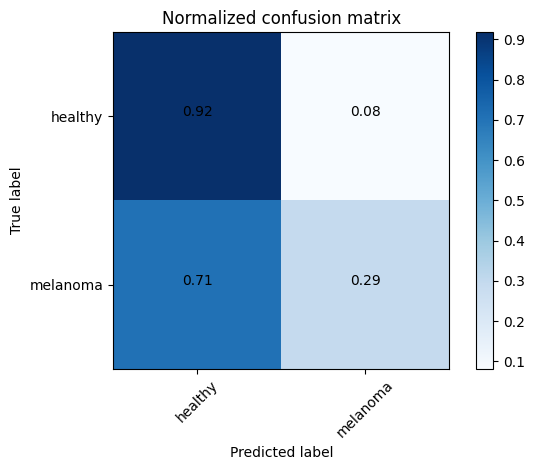

In [14]:
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())

# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
best_estimator = grid_KNN.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

The observed higher false negative rate for melanoma compared to healthy cases in the confusion matrix can be attributed to the imbalance in the dataset, where healthy samples outnumber melanoma samples. This imbalance can lead the classification algorithms, like the k-Nearest Neighbors (k-NN), to exhibit a bias towards the majority class (healthy cases), as they tend to predict the class that is more frequent in the dataset. 

Particularly for algorithms such as k-NN, which rely on the majority vote from the nearest neighbors, the presence of a higher number of healthy samples around a query point increases the likelihood of predicting the individual as healthy, thus elevating the false negative rate for melanoma.

Such imbalanced datasets pose a significant challenge in fields like medical diagnosis, where the objective often involves correctly identifying less prevalent conditions such as melanoma. 

Although the model might appear to have a high accuracy overall due to its ability to correctly predict the majority class, this metric can be misleading as it does not adequately represent the model's performance on the minority class. 

The minority class, being of greater interest or having higher consequences if misclassified, necessitates a more nuanced evaluation approach that considers metrics beyond mere accuracy to ensure a balanced performance across both classes.

In order to deal with this problem we have two possible solutions. 

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

Best training Score: 0.6066666666666667
Best training params: {'kneighborsclassifier__n_neighbors': 4}
Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.76470588 0.23529412]]


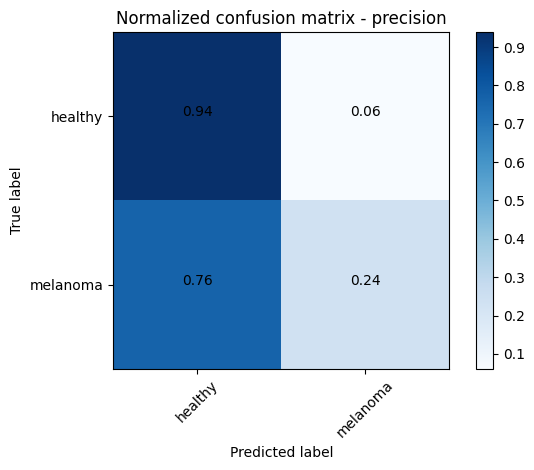

Best training Score: 0.3088235294117647
Best training params: {'kneighborsclassifier__n_neighbors': 1}
Normalized confusion matrix
[[0.84246575 0.15753425]
 [0.55882353 0.44117647]]


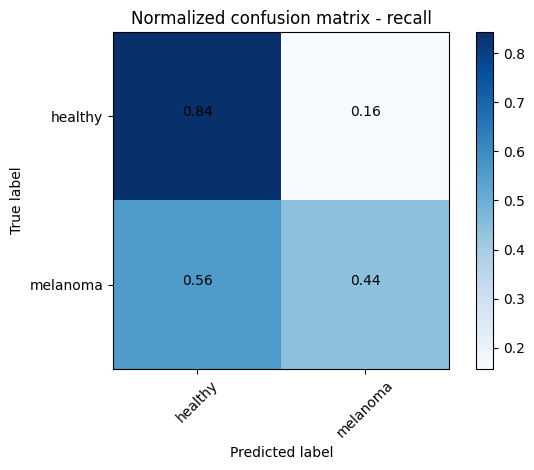

Best training Score: 0.3385166364186328
Best training params: {'kneighborsclassifier__n_neighbors': 1}
Normalized confusion matrix
[[0.84246575 0.15753425]
 [0.55882353 0.44117647]]


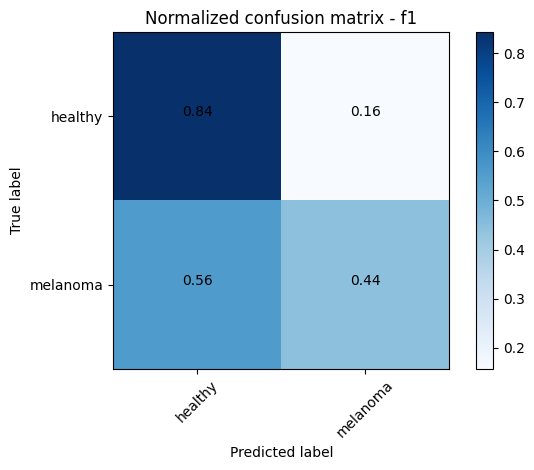

Best training Score: 0.38220610589310866
Best training params: {'kneighborsclassifier__n_neighbors': 5}
Normalized confusion matrix
[[0.91780822 0.08219178]
 [0.70588235 0.29411765]]


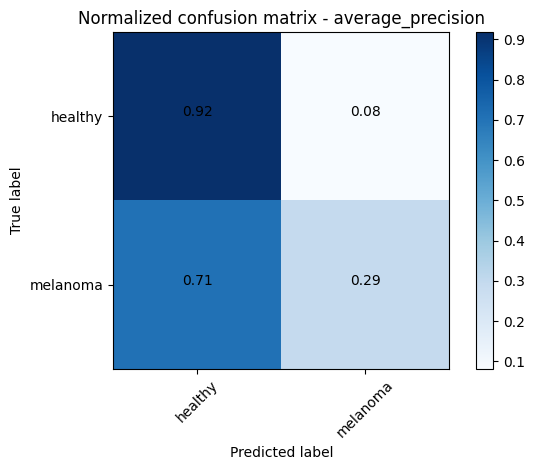

Best training Score: 0.6948982111501316
Best training params: {'kneighborsclassifier__n_neighbors': 5}
Normalized confusion matrix
[[0.91780822 0.08219178]
 [0.70588235 0.29411765]]


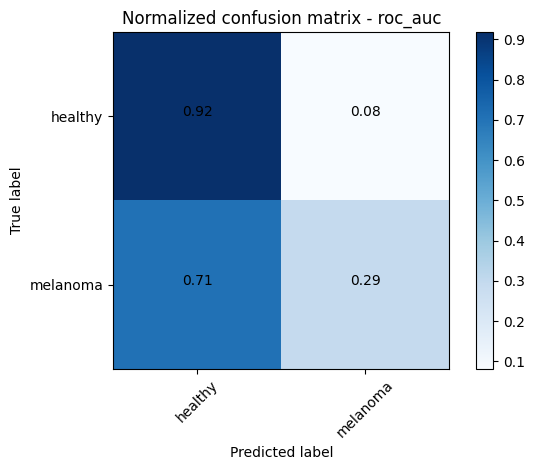

In [15]:
# Looking for the best hyperparameters using more than one metric
scoring = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1', 
           'average_precision': 'average_precision',
            'roc_auc': 'roc_auc'}

for scoring in scoring:
    grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring=scoring, cv=5)
    grid_KNN.fit(X_train, y_train)
    print("Best training Score: {}".format(grid_KNN.best_score_))
    print("Best training params: {}".format(grid_KNN.best_params_))
    best_estimator = grid_KNN.best_estimator_
    y_pred = best_estimator.predict(X_test)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)

    # Plot normalized confusion matrix 
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix - {}'.format(scoring))
    plt.show()

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.org/stable/over_sampling.html) and try at least the ADASYN over-sampling strategy (look at the following code...).

NB: if you want to use the naive random oversampling (i.e. randomly sampling with replacement) be careful not to have the same sample both in the training and validation (or test) set during cross-validation (or testing). This would be considered as a data-leakage. 

In [16]:
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 333)]


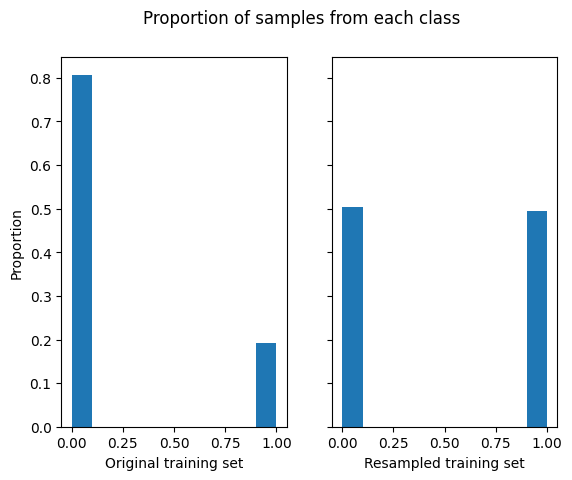

In [17]:
# Plotting the resampled data
fig, axs = plt.subplots(1, 2, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[0].set_xlabel('Original training set')
axs[1].hist(y_resampled,weights=np.ones_like(y_resampled)/len(y_resampled))
axs[1].set_xlabel('Resampled training set')
axs[0].set_ylabel('Proportion')
plt.show()

Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set. 

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

Best training Score: 0.8254075086706105
Best training params: {'kneighborsclassifier__n_neighbors': 2}
Normalized confusion matrix
[[0.82876712 0.17123288]
 [0.44117647 0.55882353]]


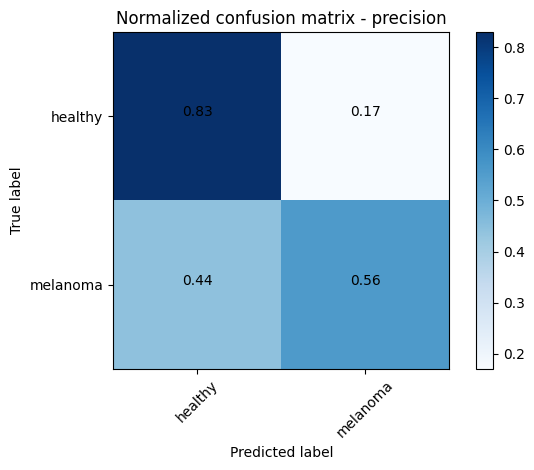

Best training Score: 0.9909543193125282
Best training params: {'kneighborsclassifier__n_neighbors': 1}
Normalized confusion matrix
[[0.7739726  0.2260274 ]
 [0.35294118 0.64705882]]


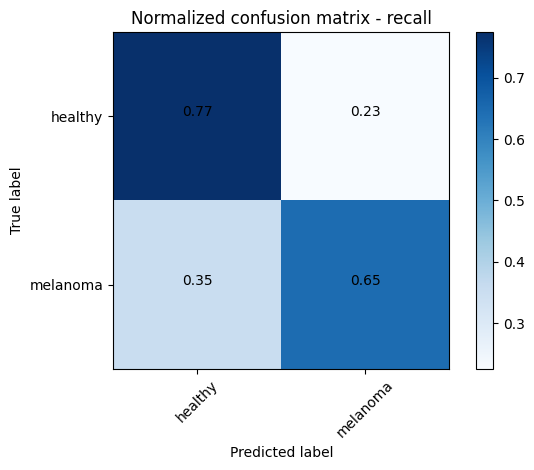

Best training Score: 0.8817962780443555
Best training params: {'kneighborsclassifier__n_neighbors': 2}
Normalized confusion matrix
[[0.82876712 0.17123288]
 [0.44117647 0.55882353]]


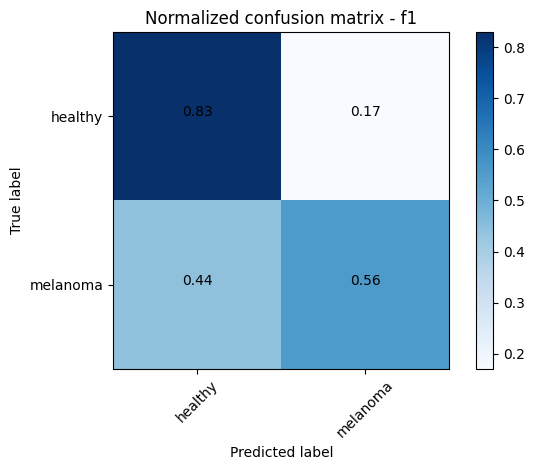

Best training Score: 0.8550824129355306
Best training params: {'kneighborsclassifier__n_neighbors': 4}
Normalized confusion matrix
[[0.70547945 0.29452055]
 [0.29411765 0.70588235]]


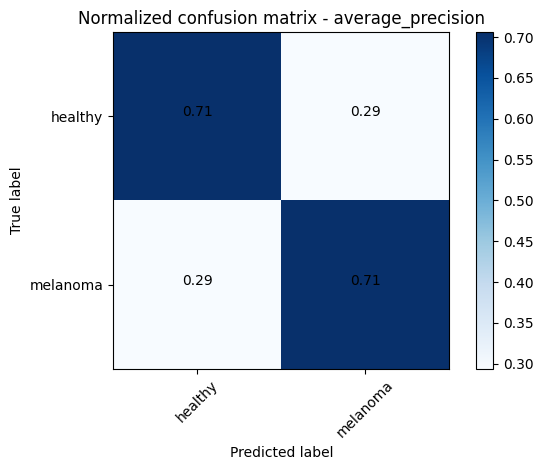

Best training Score: 0.8990708422132295
Best training params: {'kneighborsclassifier__n_neighbors': 4}
Normalized confusion matrix
[[0.70547945 0.29452055]
 [0.29411765 0.70588235]]


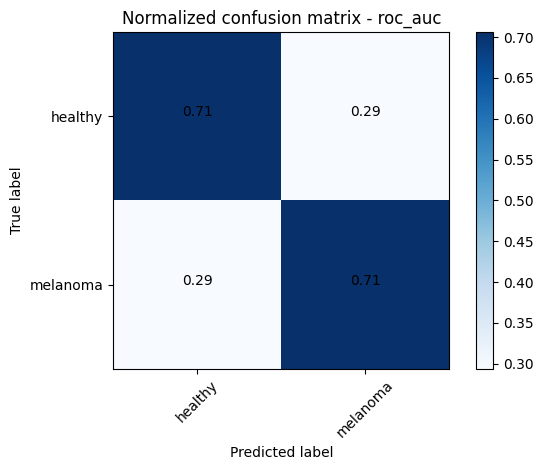

In [18]:
# Looking for the best hyperparameters using more than one metric
scoring = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1', 
           'average_precision': 'average_precision',
            'roc_auc': 'roc_auc'}

for scoring in scoring:
    neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
    p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
    grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring=scoring, cv=5)
    grid_KNN.fit(X_resampled, y_resampled)
    print("Best training Score: {}".format(grid_KNN.best_score_))
    print("Best training params: {}".format(grid_KNN.best_params_))
    best_estimator = grid_KNN.best_estimator_
    y_pred = best_estimator.predict(X_test)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)

    # Plot normalized confusion matrix 
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix - {}'.format(scoring))
    plt.show()

Resampling the training set to equalize the proportions of 'healthy' and 'melanoma' classes significantly improves the performance of the k-NN algorithm, especially in classifying the previously underrepresented melanoma class. 

This adjustment addresses the imbalance issue, reducing the bias towards the majority class and enhancing the model's ability to identify cases of melanoma more accurately. When the training data is balanced, the k-NN model benefits from a more representative sample of the population, which in turn allows for a more reliable classification of both classes.

The selection of the optimal 'k' value in k-NN is also influenced by the choice of scoring function. Traditional accuracy metrics may prioritize overall performance, often at the expense of the minority class. In contrast, employing scoring functions like precision, recall, F1 score, or the ROC-AUC score can lead to the selection of a 'k' value that ensures a better balance between detecting positive cases (true positives) and avoiding false alarms (false positives). 

These metrics consider the model's performance in a more nuanced way, focusing on the quality and completeness of positive class predictions. As a result, with a balanced dataset and a carefully chosen scoring function, the k-NN model becomes more adept at generalizing across both classes, thereby improving its diagnostic utility and fairness.

Let's use the techniques seen today: Perceptron and linear SVM. 

In [19]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC()) 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.7470833333333334 +- 0.0776231101040291
 Average and std TEST CV accuracy : 0.7333333333333334 +- 0.0560257877132387
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8445833333333332 +- 0.008186201126828514
 Average and std TEST CV accuracy : 0.8150000000000001 +- 0.027588242262078077


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [20]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC()) 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7470833333333334 +- 0.0776231101040291
 Average and std TEST CV accuracy : 0.7333333333333334 +- 0.0560257877132387
 Average and std TRAIN CV f1 : 0.35373231691129065 +- 0.09920379279242053
 Average and std TEST CV f1 : 0.31268115942028984 +- 0.13015303261005437
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8445833333333332 +- 0.009185586535436885
 Average and std TEST CV accuracy : 0.8166666666666667 +- 0.030276503540974907
 Average and std TRAIN CV f1 : 0.4232648148148147 +- 0.0545303088347999
 Average and std TEST CV f1 : 0.3179002891479172 +- 0.12405616130539299


**Question** Please do the same on the oversampled data and compare the results with the previous ones. Please note that here you should use the ‘make_pipeline‘ function of Imbalanced scikit-learn. You can look here:  [LINK](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.make_pipeline.html)


In [21]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp, cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Fitting linear SVM on oversampled data
print("Fitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6779166666666667 +- 0.06692138837637952
 Average and std TEST CV accuracy : 0.64 +- 0.08698658900466592
 Average and std TRAIN CV f1 : 0.43482291727742783 +- 0.06267577882127977
 Average and std TEST CV f1 : 0.3819810575100647 +- 0.056281050480672015
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.75875 +- 0.013527235900623257
 Average and std TEST CV accuracy : 0.6966666666666667 +- 0.05286250509051238
 Average and std TRAIN CV f1 : 0.5236461400119602 +- 0.03078861685972656
 Average and std TEST CV f1 : 0.41094336951343396 +- 0.06959177397845218


For the **Perceptron Algorithm**:

- When trained on the imbalanced dataset, the Perceptron shows a higher mean training accuracy compared to when trained on the balanced dataset (around 75% versus 68%), while the mean test accuracy is marginally better on the imbalanced dataset (around 73% versus 64%).
- The f1 score, a crucial metric considering the imbalanced nature of the classes, saw an improvement on the balanced dataset. The mean test f1 score rose from approximately 31% to 38%.

For the **Support Vector Machine (SVM) with Linear Kernel**:

- Echoing the Perceptron's trend, the SVM with Linear Kernel witnessed a slight decrease in mean training accuracy on the balanced dataset (from roughly 84% to 76%) and a reduction in mean test accuracy (from around 82% to 70%).
- The f1 score experienced a boost similar to that of the Perceptron, with the mean test f1 score climbing from about 32% to 41%.

Analyzing both algorithms and datasets reveals:

- **Precision versus F1 Metric**: The mean accuracy dipped on the balanced dataset for both algorithms, yet the f1 metrics saw enhancements. This shift is anticipated as accuracy can be misleading in imbalanced datasets, with models possibly achieving high accuracy by predominantly predicting the more common class.

- **Algorithm Efficacy**: The uplift in the f1 metric with the balanced dataset indicates that both algorithms have improved in identifying the minority class (likely melanoma in this context). This enhancement is particularly vital in areas like medical diagnostics, where missing a diagnosis has severe implications.

- **Generalization over Overfitting**: The drop in accuracy could also hint at the algorithms initially overfitting to the predominant class in the imbalanced dataset and now offering a more balanced generalization across classes.

- **Utilizing a Balanced Dataset**: The balanced training dataset necessitated that the algorithms equally consider the traits of both classes. This adjustment is probably the reason for the enhanced f1 scores, signifying a more equitable balance between precision and recall.

We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data. 
In that case, we will need to first split the data into train/test and then do the oversampling ONLY in the train data. 

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.669047619047619 +- 0.07574740964565858
 Average and std TEST CV accuracy : 0.6309523809523809 +- 0.1070105002583059
 Average and std TRAIN CV f1 : 0.4263688562490239 +- 0.05309524411987356
 Average and std TEST CV f1 : 0.34571379428964566 +- 0.07875949805782699
Normalized confusion matrix
[[0.79452055 0.20547945]
 [0.38235294 0.61764706]]


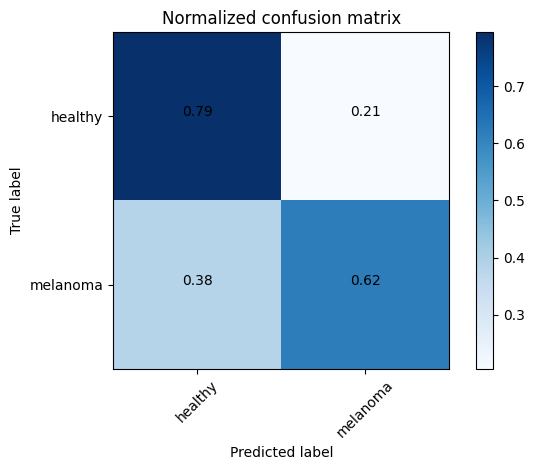

Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.7553571428571428 +- 0.01426089113179873
 Average and std TEST CV accuracy : 0.6880952380952381 +- 0.0138832187972507
 Average and std TRAIN CV f1 : 0.5215364727124447 +- 0.027488520982421095
 Average and std TEST CV f1 : 0.3907337699169804 +- 0.020955941465071928
Normalized confusion matrix
[[0.76712329 0.23287671]
 [0.32352941 0.67647059]]


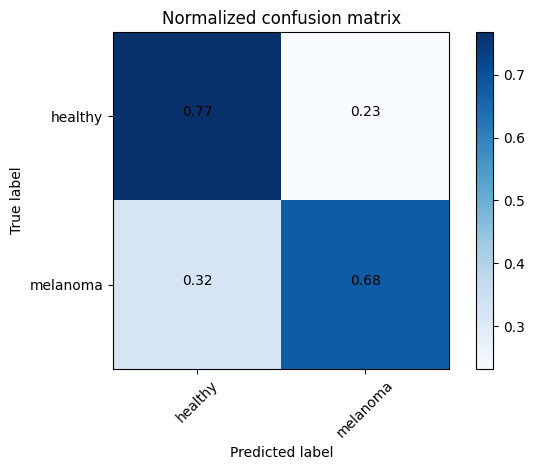

In [22]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best = Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


# Fitting linear SVM
print("Fitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_accuracy'])
estimator_best=Lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model. 

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

Best training Score: 0.7142857142857143
Best training params: {'linearsvc__C': 0.001}
Normalized confusion matrix
[[0.80136986 0.19863014]
 [0.26470588 0.73529412]]


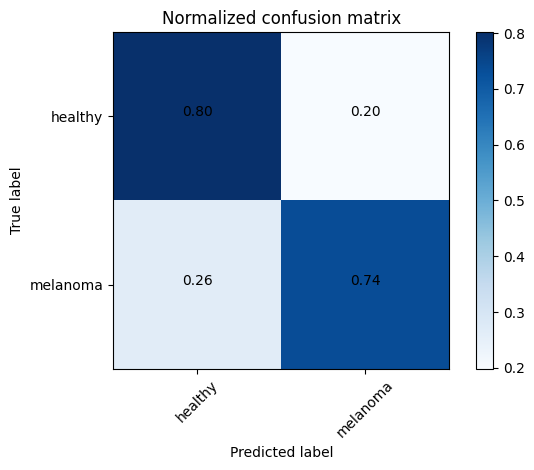

In [23]:
# Looking for the best hyperparameter C 
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC()) 
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
best_estimator = grid_lsvm.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training Score: 0.8142857142857143
Best training params: {'svc__C': 0.1, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.80136986 0.19863014]
 [0.26470588 0.73529412]]


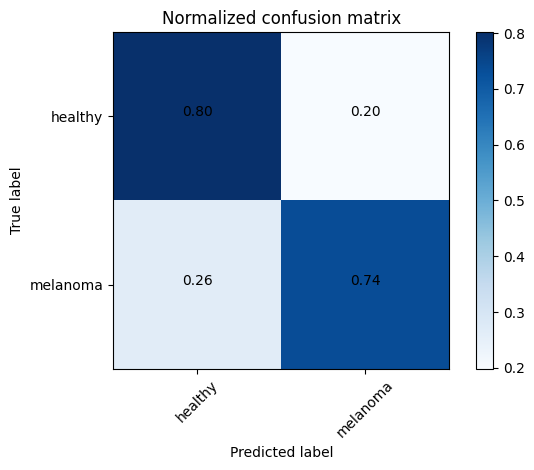

In [24]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), SVC(kernel='rbf')) 
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
best_estimator = grid_lsvm.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

c:\Users\Daniel Torres\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Daniel Torres\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Daniel Torres\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Best training Score: 0.6214285714285713
Best training params: {'svc__C': 4, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.80136986 0.19863014]
 [0.26470588 0.73529412]]


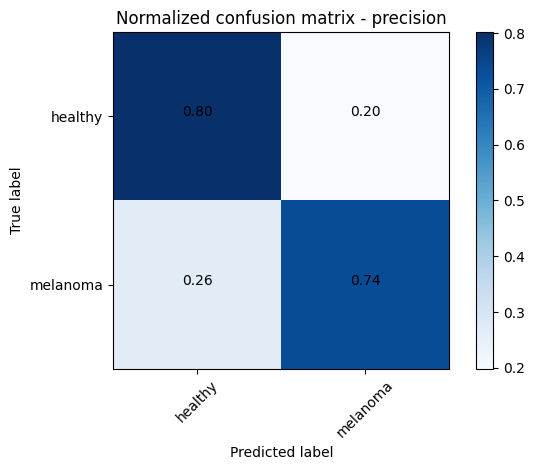

Best training Score: 0.5933823529411765
Best training params: {'svc__C': 3, 'svc__gamma': 0.005}
Normalized confusion matrix
[[0.80136986 0.19863014]
 [0.26470588 0.73529412]]


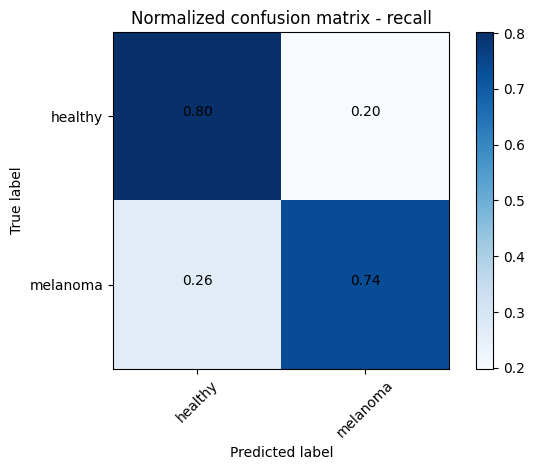

Best training Score: 0.5061294675895694
Best training params: {'svc__C': 7, 'svc__gamma': 0.01}
Normalized confusion matrix
[[0.80136986 0.19863014]
 [0.26470588 0.73529412]]


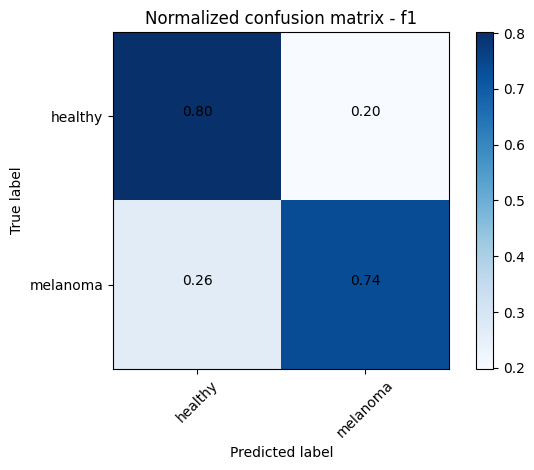

Best training Score: 0.5211094763881916
Best training params: {'svc__C': 7, 'svc__gamma': 0.01}
Normalized confusion matrix
[[0.80136986 0.19863014]
 [0.26470588 0.73529412]]


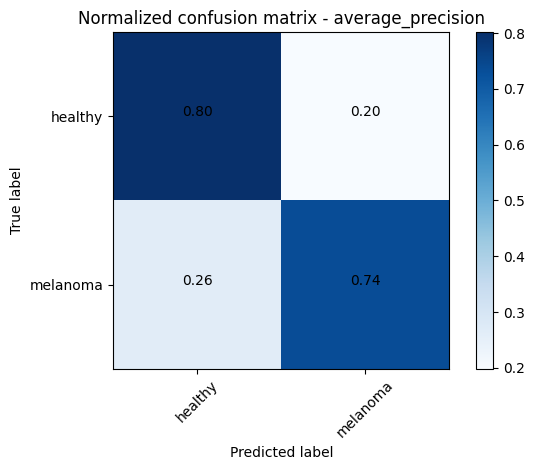

Best training Score: 0.7314146180860404
Best training params: {'svc__C': 2, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.80136986 0.19863014]
 [0.26470588 0.73529412]]


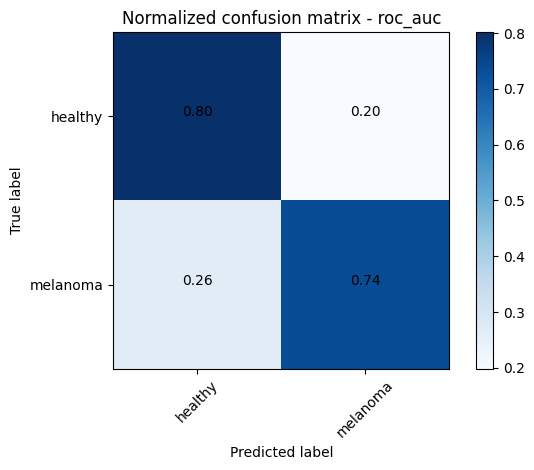

In [25]:
# Non-linear SVM with different scoring metrics
scoring = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1', 
           'average_precision': 'average_precision',
            'roc_auc': 'roc_auc'}

for scoring in scoring:
    grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring=scoring, cv=5)
    grid_nlsvm.fit(X_train, y_train)
    print("Best training Score: {}".format(grid_nlsvm.best_score_))
    print("Best training params: {}".format(grid_nlsvm.best_params_))
    best_estimator = grid_lsvm.best_estimator_
    y_pred = best_estimator.predict(X_test)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)

    # Plot normalized confusion matrix 
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix - {}'.format(scoring))
    plt.show()

Fitting Non-linear SVM to the training set
Best training Score: 0.5061294675895694
Best training params: {'svc__C': 7, 'svc__gamma': 0.01}
Normalized confusion matrix
[[0.80136986 0.19863014]
 [0.26470588 0.73529412]]


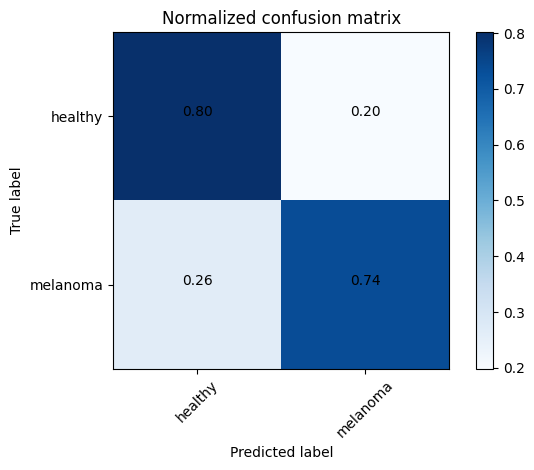

In [26]:
# Non-linear SVM with oversampled data
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), SVC(kernel='rbf'))
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="f1", cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
best_estimator = grid_lsvm.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Support Vector Machine with Linear Kernel:**
Support Vector Machines (SVMs) with a linear kernel are optimal for datasets where classes are linearly separable or nearly so. In scenarios where the dataset is imbalanced, linear SVMs are expected to show enhanced performance for the majority class while potentially faltering on the minority class, given the insufficient minority class representation to delineate complex decision boundaries accurately.

**Support Vector Machine with Non-Linear Kernel:**
Non-linear SVMs are tailored for situations where the class boundary is non-linear, employing transformations to project the feature space into a higher dimension where linear separation becomes feasible. When applied to an oversampled dataset, non-linear SVMs gain access to a broader array of examples from the minority class, enabling the identification of more intricate patterns and relationships critical for class differentiation.


In comparing the efficacy of linear versus non-linear SVMs on oversampled datasets, the anticipated outcomes include:

- A superior true positive rate for the minority class may be observed with the non-linear SVM, attributed to its proficiency in recognizing complex data relationships.
- The precision for the minority class might decrease as the model could begin attributing more instances to the minority class, leading to an increase in false positives.
- An elevated recall for the minority class is expected, as the non-linear SVM is likely more adept at identifying true positive instances within the minority class.
- The F1 score, which seeks a balance between precision and recall, could see an improvement for the non-linear SVM on an oversampled dataset, reflecting its enhanced capacity for accurately classifying minority class instances without a significant compromise in precision.
- An improvement in average precision might be noted if the non-linear SVM manages to sustain precision across varying levels of recall.
- The ROC-AUC score for the non-linear SVM could surpass that of its linear counterpart, owing to an improved balance between the true positive and false positive rates.

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

1. **Issue of Class Disparity**:
   - The initial dataset exhibited a significant class imbalance problem, adversely impacting model accuracy, especially for the underrepresented class, such as melanoma. Addressing this imbalance is crucial for enhancing model sensitivity towards the minority class.

2. **Enhancement in Model Efficacy**:
   - Both linear and non-linear SVM models demonstrated improved efficacy on the balanced dataset, as evidenced by elevated F1 scores, underscoring the advantage of rectifying class distribution disparities.
   - Specifically, the non-linear SVM showed notable improvement, benefiting from the complexity of the decision boundaries enabled by the balanced dataset.

3. **Importance of Evaluation Metrics**:
   - In medical diagnostics, metrics like the F1 score, recall, and ROC-AUC are pivotal, offering a balanced perspective on the trade-offs between false negatives and false positives. These metrics experienced an uptick with the balanced dataset, indicating enhanced precision in identifying the minority class.

4. **Medical Consequences**:
   - Within the realm of melanoma detection, overlooking a true case (false negative) poses a greater risk than incorrectly identifying a case (false positive), which can be further scrutinized through additional tests. Thus, a model with superior sensitivity (recall) for detecting melanoma is more desirable, even at the expense of increased false positives.

5. **Considerations for Computational Demand**:
   - Despite the potentially superior accuracy of non-linear SVMs, their increased computational demand warrants consideration. The decision between linear and non-linear models hinges on the balance between performance gains and computational efficiency, particularly where swift diagnostic processes are essential.

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

Fitting Linear SVM after PCA
Best training Score: 0.7071428571428571
Best training params: {'linearsvc__C': 0.01}
Normalized confusion matrix
[[0.80136986 0.19863014]
 [0.23529412 0.76470588]]


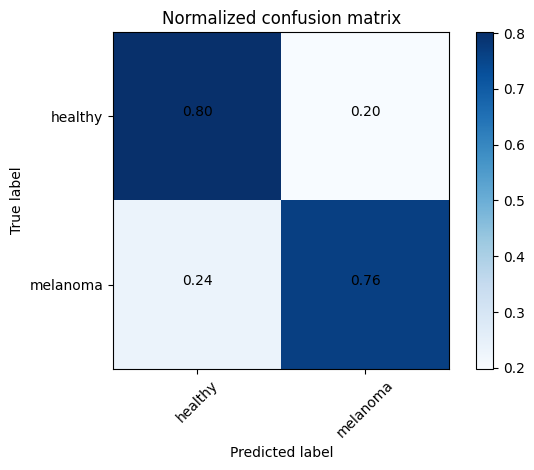

In [27]:
# Test PCA with a linear SVM
print("Fitting Linear SVM after PCA")

Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), PCA(n_components=0.95), LinearSVC()) 
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}

grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
best_estimator = grid_lsvm.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 


[2024-03-19 20:51:54] Features: 1/10 -- score: 0.7452380952380953
[2024-03-19 20:51:59] Features: 2/10 -- score: 0.7404761904761905
[2024-03-19 20:52:04] Features: 3/10 -- score: 0.7214285714285715
[2024-03-19 20:52:09] Features: 4/10 -- score: 0.7285714285714286
[2024-03-19 20:52:14] Features: 5/10 -- score: 0.7404761904761905
[2024-03-19 20:52:18] Features: 6/10 -- score: 0.75
[2024-03-19 20:52:23] Features: 7/10 -- score: 0.7523809523809524
[2024-03-19 20:52:28] Features: 8/10 -- score: 0.7547619047619047
[2024-03-19 20:52:32] Features: 9/10 -- score: 0.7547619047619047
[2024-03-19 20:52:37] Features: 10/10 -- score: 0.7404761904761905

Best accuracy obtained was: 0.7404761904761905
Indices of the selected features: (0, 5, 7, 8, 20, 21, 22, 26, 27, 28)
Number of selected features: 10


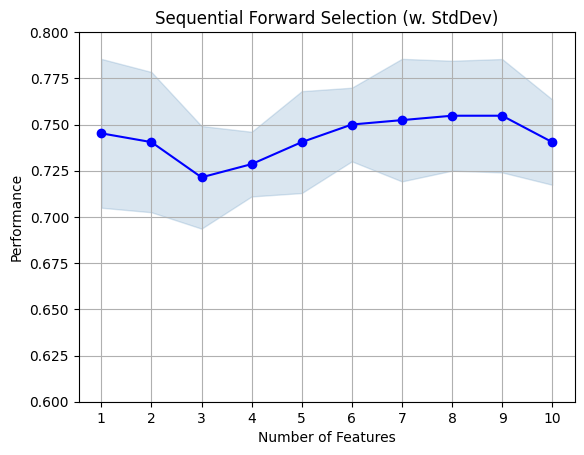

In [28]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM

# Set up the cross-validation scheme
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize the linear SVM
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC(C=1))

# Initialize the SFS
sfs = SFS(Lsvm, 
          k_features=10, 
          forward=True, 
          floating=False, 
          verbose=2,
          scoring='accuracy',
          cv=skf)

# Perform SFS
sfs = sfs.fit(X_train, y_train)

# Print the results
print('Best accuracy obtained was:', sfs.k_score_)
print('Indices of the selected features:', sfs.k_feature_idx_)
print('Number of selected features:', len(sfs.k_feature_idx_))

# Plot the results
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.6, 0.8])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
